<a href="https://colab.research.google.com/github/Dehan001/Computer-Vision/blob/main/image_semantic_segmention_binary_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Task 1: Setup google colab runtime environment**

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git++https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

ERROR: Invalid requirement: 'git++https://github.com/albumentations-team/albumentations': Expected end or semicolon (after name and no valid version specifier)
    git++https://github.com/albumentations-team/albumentations
       ^
Hint: It looks like a path. File 'git++https://github.com/albumentations-team/albumentations' does not exist.


**Download Dataset**

In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


**Import necessary libraries**

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch
import cv2

import  numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

**Efficientnet, U-Net, FPN, or DeepLab**

In [ ]:
CSV_Path = '/content/Human-Segmentation-Dataset-master/train.csv'
data_path = '/content'
device = 'cuda'

epochs = 25
lr = 0.003
image_size = 320
batch_size = 16
encoder = 'timm-efficientnet-b0'
weights = 'imagenet'


In [ ]:
df = pd.read_csv(CSV_Path)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row = df.iloc[4]

mask_path = row.masks
image_path = row.images

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255.00


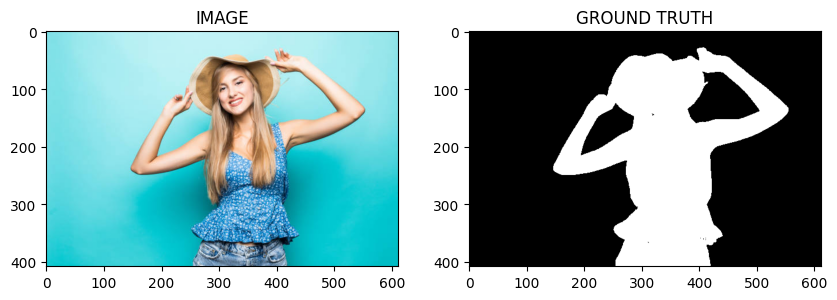

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask, cmap='gray')

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

**Augmentation Function**

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
      A.Resize(image_size, image_size), # Resize both image and mask to the same dimensions before applying other augmentations
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5),
  ], is_check_shapes=False)  # specify the additional targets for the augmentation pipeline


def get_valid_augs():
  return A.Compose([
      A.Resize(image_size, image_size), # Resize both image and mask to the same dimensions
  ], is_check_shapes=False)  # specify the additional targets for the augmentation pipeline

**Custom Dataset**

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):

    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis=-1)

    if self.augmentations:
      data = self.augmentations(image=image, mask=mask)
      image = data['image']
      mask = data['mask']
    #pytorch uses channel, height, width conventions

    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)
    image = torch.Tensor(image)/255.0
    mask = torch.round(torch.Tensor(mask)/255.0)

    return image, mask



In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print('Size of transet', len(trainset))
print('Size of testset', len(validset))

Size of transet 232
Size of testset 58


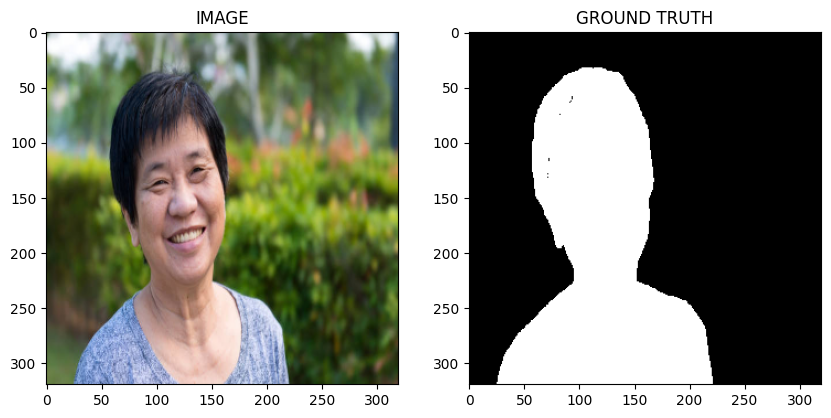

In [ ]:
idx = 3
image, mask = trainset[idx]
helper.show_image(image, mask)

**Working with batches**

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(validset, batch_size=batch_size)

In [ ]:
print(f'Total number of batch sizes in train loader:{len(train_loader)}')
print(f'Total number of batch sizes in valid loader:{len(valid_loader)}')

Total number of batch sizes in train loader:15
Total number of batch sizes in valid loader:4


In [ ]:
for image, mask in train_loader:
  break
print(f'Shape of one batch of image: {image.shape}')
print(f'Shape of one batch of mask: {mask.shape}')

Shape of one batch of image: torch.Size([16, 3, 320, 320])
Shape of one batch of mask: torch.Size([16, 1, 320, 320])


**Segmentation Model**

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = encoder,
        encoder_weights = weights,
        in_channel = 3,
        classes = 1,
        activation = None
    )
  def forward(self, images, masks=None):
    logits = self.arc(images)
    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits,masks)
      loss2 = nn.BCEWithLogitsLoss()(logits,masks)
      return logits, loss1+loss2
    return logits

In [ ]:
model = SegmentationModel()
model.to(device)

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 117MB/s] 


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

**Training**

In [ ]:
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(device)
    masks = masks.to(device)

    optimizer.zero_grad()
    logits,loss = model(images, masks)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  return total_loss/len(data_loader)


**Evaluating**

In [ ]:
def eval_fn(data_loader, model):

  model.eval()
  total_loss = 0.0
  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(device)
      masks = masks.to(device)

      logits,loss = model(images, masks)

      total_loss += loss.item()
  return total_loss/len(data_loader)

**Training**

In [75]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

best_valid_loss = np.inf
for epoch in range(epochs):
  train_loss = train_fn(train_loader, model, optimizer)
  valid_loss = eval_fn(valid_loader, model)

  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'best_model.pt')
    print('Best model saved!')
  print(f'Epoch: {epoch+1} Train Loss: {train_loss} Eval Loss:{valid_loss}')

NameError: name 'train_fn' is not defined

**Inference Generation**

In [ ]:
idx = 20

torch.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(device).unsqueeze()) #c, h, w -> 1, c, h, w

pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0
pred_mask = pred_mask.detach().cpu().squeeze(0)


In [ ]:
helper.show_image(image, mask, pred_mask)